# Script de test
## - Traitement données LVF gen0 observation du spectralon depuis le D301 à 12h
## - Données 2023-02-16 IPAG Silvere Gousset 

### 0 - Importation des librairies

In [1]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.ndimage import sobel
from scipy.signal import correlate2d
import cv2
import matplotlib as matplot
import scipy.optimize as so  
import sys
sys.path.append(r'C:\Users\goussets\LIB_PYTHON')
from lvflib import ImSPOCFitsClass, ImSPOCDataClass, make_centerbox_corr, preprocess_data, image_centroid, corr_multibox, readandproc_pm101, readfitscube_frommultifile,anafct_gaussian,fitlvf_isrf,extract_3dmed

ModuleNotFoundError: No module named 'cv2'

### 1 - Chargement et pré-traitement des données
On utilise la fonction preprocess_data, qui permet de faire une moyenne (médiane) temporelle d'une séquence d'images, de faire la même chose pour une séquence de fond, mais également de corriger le tramage horizontal des images de fond ("temporal noise" du HDPYX).

In [3]:
datapath=r'C:\Users\goussets\DATA_ACQ\LVF_GEN0\20230216_spectralonSun\data_cit500'
datafilebasename='-'
darkpath=r'C:\Users\goussets\DATA_ACQ\LVF_GEN0\20230216_spectralonSun\dark_cit500'
darkfilebasename='-'

data = preprocess_data(datapath,datafilebasename,exten_no_start=0,path_dark=darkpath,filebase_dark=darkfilebasename,SubRow_dark=True)

NameError: name 'preprocess_data' is not defined

#### Output tuple[1] : Image "brute"

In [ ]:
fig0, (ax0) = matplot.pyplot.subplots(1,1,figsize=(15, 12))#,figsize=(8, 6)
ax0.imshow(data[1],origin='lower')

####  Output tuple[0] : Image pré-traitée

In [2]:
fig1, (ax1) = matplot.pyplot.subplots(1,1,figsize=(15, 12))#,figsize=(8, 6)
ax1.imshow(data[0],origin='lower')

NameError: name 'matplot' is not defined

####  Output tuple[2] : Image de fond pré-traitée

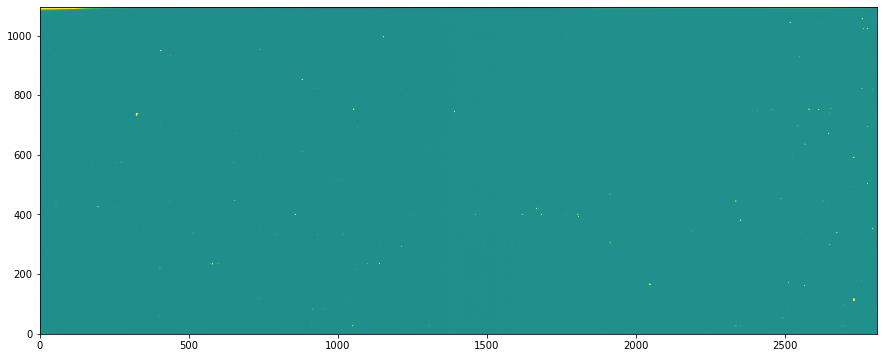

In [6]:
fig2, (ax2) = matplot.pyplot.subplots(1,1,figsize=(15, 12))#,figsize=(8, 6)
ax2.imshow(data[2],vmin=-1000,vmax=1000,origin='lower')

####  Output tuple[3] : fichier hdul avec image prétraitée dans les data et header de la première image

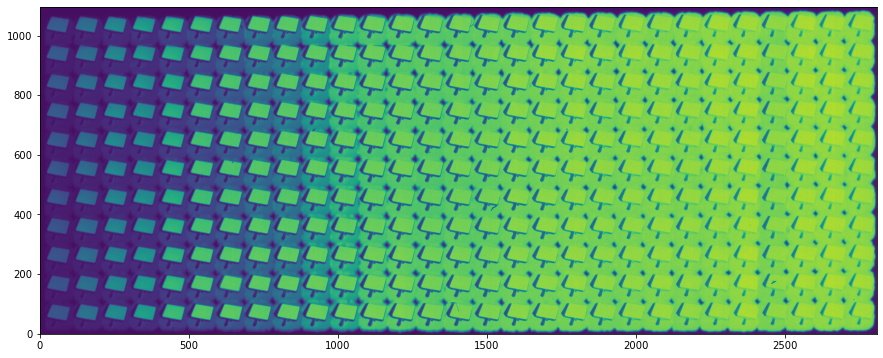

In [7]:
temphdul=data[3]
fig3, (ax3) = matplot.pyplot.subplots(1,1,figsize=(15, 12))#,figsize=(8, 6)
ax3.imshow(temphdul[0].data,origin='lower')

### 2 - Création d'un object ImSPOC
On crée l'objet "donnée ImSPOC" par ImSPOCDataClass. On ne passe pas par la classe ImSPOCFitsClass qui permet d'ouvrir et d'instancier des données fits, car on a du au préalable pré-traiter la séquence d'acquisitions.
#### /!\ _startpix dans le format (axe horizontal, axe vertical), convertit dans le format python ensuite (axe vertical, axe horizontal)

In [8]:
print(temphdul[0].header)
ImSPOCinst=ImSPOCDataClass(temphdul[0].data,temphdul[0].header,thumbsize=[96,96],thumbpitch=[96,96],winsize=[80,80],_startpix=[1403,537])

SIMPLE  =                    T  / DELTATEC BASIC FITS FORMAT                    BITPIX  =                  -64                                                  NAXIS   =                    2                                                  NAXIS1  =                 2808                                                  NAXIS2  =                 1096                                                  DATE    = '2023-02-16T12:32:46'                                                 PXLFMT  = 'Mono20  '                                                            OFFSETX = '0       '                                                            OFFSETY = '0       '                                                            FRAMENB = '8837    '                                                            TIME    = '1457381841040'                                                                                                                                       END                                     

 [astropy.io.fits.verify]


#### Overlay des donnée avec centre des imagettes, masque géométrique des imagettes, et index des imagettes

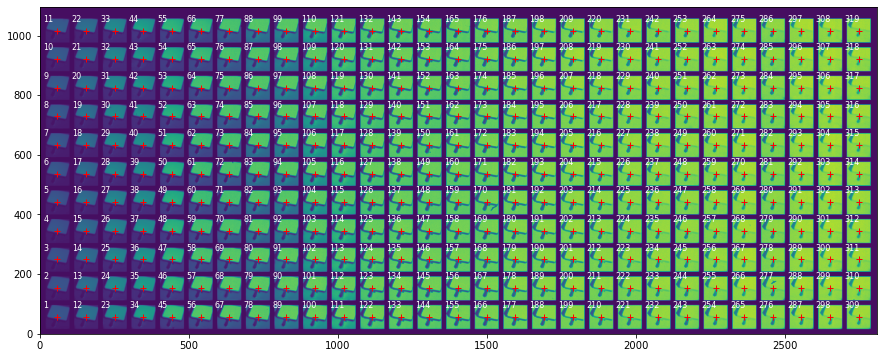

In [9]:
fig, (ax) = matplot.pyplot.subplots(1,1,figsize=(15, 12))#,figsize=(8, 6)
ax.imshow(ImSPOCinst.data*ImSPOCinst.mskval,origin='lower')#,vmin=0,vmax=1000
ax.plot(ImSPOCinst.centre[:,0],ImSPOCinst.centre[:,1],'r+')  
for i in range(0,np.size(ImSPOCinst.centre,axis=0)):
    ax.text(ImSPOCinst.centre[i,0]-48,ImSPOCinst.centre[i,1]+30,str(ImSPOCinst.mskthumbnail[ImSPOCinst.centre[:,:][i,1],ImSPOCinst.centre[:,:][i,0]]),color='white',fontsize=8)

### 4 - Test fonction de recalage entre imagette
#### Recalage des imagettes suivant masque a priori
    - scipy.interpolate.interp2d => /!\ DEPRECIATED et ne marche pas ?
    - scipy.interpolate.CloughTocher2DInterpolator => remplace maintenant 
    - scipy.interpolate.RBFInterpolator => Utilisé par Jean-Charles Baritaux

Jean-Charles Baritaux mail 3/10/2023 :

"Après on fait un premier recalage au pixel entier. Puis on interpole le résidu de disparité sous-pixel avec un « radial basis function interpolator », ce qui nous donne un champ de déformation. On utilise l’implémentation de scipy  RBFInterpolator. Pour cette interpolation j’ai essayé des splines et des polynomes de zernike. Le RBF est un peu mieux sur les bords de l’image, là où il n’y a pas de point de calibration. Et pour le calcul de l’image déformée on utilise la fonction warp de scikit-image (le mode par défaut, bilinéaire)."

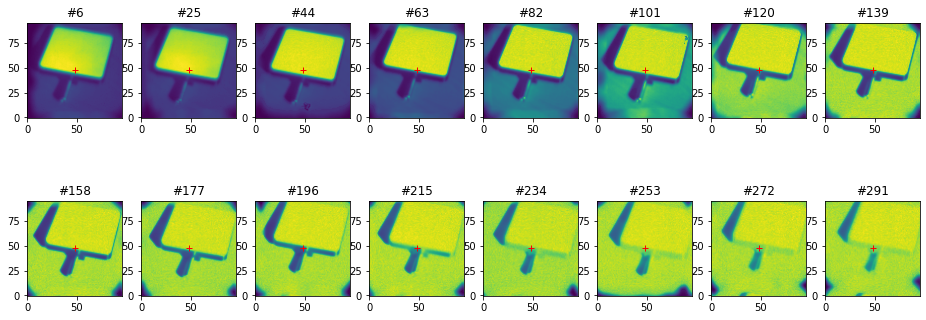

In [10]:
istart=6
step=19#11
nro=2
nco=8
fig,(ax) = matplot.pyplot.subplots(nrows=nro, ncols=nco,figsize=(16, 6))#
i=0
for a in range(0,nro):
    for b in range(0,nco):
        ax[a,b].imshow(ImSPOCinst.data_3D[:,:,istart+i*step],origin='lower'),ax[a,b].plot(48,48,'r+')
        ax[a,b].set_title('#'+str(istart+i*step))#,fontsize=20
        i+=1

### 5b - Recalage des imagettes
Deux procédures testées :
- a) Evaluation du décalage sub-pixel par corrélation d'imagette, b) puis interpolation pour recalage [Step 0, 1, 2]
- a) Evaluation du décalage sub-pixel par corrélation d'imagette, b) ajustement des centres au pixel près [Step 3], c) Corrélation autour des centres réajustés pour décalage fin [Step 4], d) Recalage fin [Step 5]

La procédure 2 marche beaucoup moins bien, entre autre à cause de la fenetre des imagettes qui se déplace sur les pixels entre imagettes et oblige à réduire la fenetre de calcul de la corrélation. Des problèmes d'interpolation on été vu également ?

#### Step 0 > Test/Debug de la procédure de recalage sur imagette unique

Correlation centroid:  [92.09809834 91.63879825]
Pixel displacement:  [3.09809834 2.63879825]


(<matplotlib.image.AxesImage at 0x22053521e20>,
 Text(0.5, 1.0, ''),
 None)

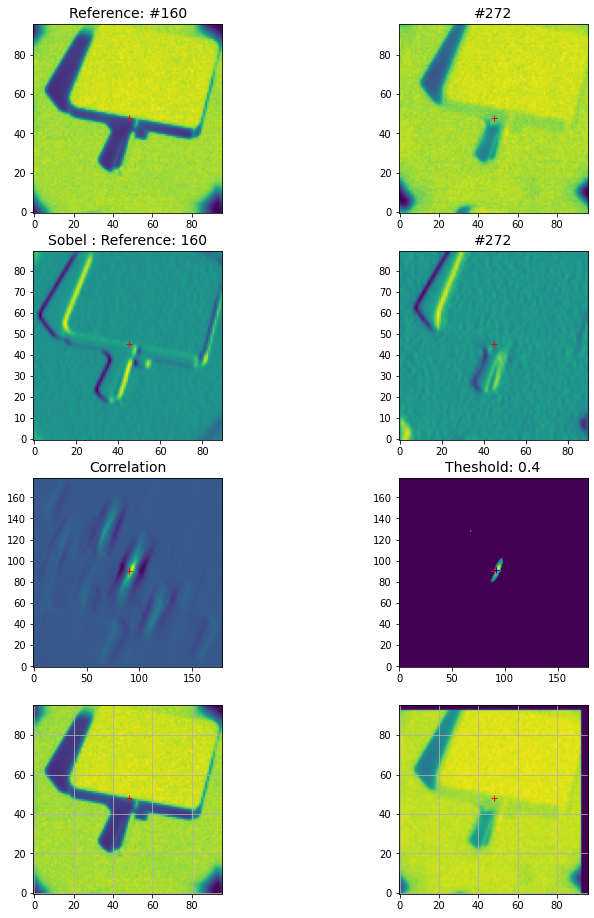

In [11]:
# . SELECTION IMAGETTE ET CROP
ithumbref=160
t=272#318#317#20#177#20
win_size=90#40
ref_crop=ImSPOCinst.data_3D[int(48-win_size/2):int(48+win_size/2),int(48-win_size/2):int(48+win_size/2),ithumbref]
thu_crop=ImSPOCinst.data_3D[int(48-win_size/2):int(48+win_size/2),int(48-win_size/2):int(48+win_size/2),t]
# . FILTRAGE DE SOBEL
ref_crop_sob=sobel(ref_crop)
ref_crop_sob/=np.max(ref_crop_sob)
thu_crop_sob=sobel(thu_crop)
thu_crop_sob/=np.max(thu_crop_sob)
# . Corrélation cross-imagette
corr=correlate2d(thu_crop_sob,ref_crop_sob, mode='full', boundary='fill', fillvalue=0)
# . Application seuil tronqué
thres_perc=0.4#25
ret, corr_thresh = cv2.threshold(corr, thres_perc*np.max(corr), 1, cv2.THRESH_TOZERO)

# . Calcul CDG et deplacement pixellique
centroid=image_centroid(corr_thresh)
print('Correlation centroid: ',centroid)

pix_displ=centroid-[win_size,win_size]+[1,1] # /!\ reajusté avec auto correlation sur imagette du centre
print('Pixel displacement: ',pix_displ)

# . interpolating
_xref=ImSPOCinst.mapfov[ ImSPOCinst.centre[ithumbref,1]-int(ImSPOCinst.thumbsize[1]/2):ImSPOCinst.centre[ithumbref,1]+int(ImSPOCinst.thumbsize[1]/2), ImSPOCinst.centre[ithumbref,0]-int(ImSPOCinst.thumbsize[0]/2):ImSPOCinst.centre[ithumbref,0]+int(ImSPOCinst.thumbsize[0]/2) ,0]
_yref=ImSPOCinst.mapfov[ ImSPOCinst.centre[ithumbref,1]-int(ImSPOCinst.thumbsize[1]/2):ImSPOCinst.centre[ithumbref,1]+int(ImSPOCinst.thumbsize[1]/2), ImSPOCinst.centre[ithumbref,0]-int(ImSPOCinst.thumbsize[0]/2):ImSPOCinst.centre[ithumbref,0]+int(ImSPOCinst.thumbsize[0]/2) ,1]
_xref1d=np.reshape(_xref,(ImSPOCinst.thumbsize[0]*ImSPOCinst.thumbsize[1]))
_yref1d=np.reshape(_yref,(ImSPOCinst.thumbsize[0]*ImSPOCinst.thumbsize[1]))

_x1d=_xref1d-pix_displ[0]
_y1d=_yref1d-pix_displ[1]
_z1d=np.reshape(ImSPOCinst.data_3D[:,:,t],(ImSPOCinst.thumbsize[0]*ImSPOCinst.thumbsize[1]))
_interp = CloughTocher2DInterpolator(list(zip(_x1d, _y1d)), _z1d,fill_value=0)

_znew1d=_interp(list(zip(_xref1d,_yref1d)))   
_znew=np.reshape(_znew1d,(ImSPOCinst.thumbsize[0],ImSPOCinst.thumbsize[1]))

# . ploplot
fig,(ax) = matplot.pyplot.subplots(nrows=4, ncols=2,figsize=(12, 16))#
ax[0,0].imshow(ImSPOCinst.data_3D[:,:,ithumbref],origin='lower'),ax[0,0].plot(48,48,'r+'),ax[0,0].set_title('Reference: #'+str(ithumbref),fontsize=14)
ax[0,1].imshow(ImSPOCinst.data_3D[:,:,t],origin='lower'),ax[0,1].plot(48,48,'r+'),ax[0,1].set_title('#'+str(t),fontsize=14)
ax[1,0].imshow(ref_crop_sob,origin='lower'),ax[1,0].set_title('Sobel : Reference: '+str(ithumbref),fontsize=14),ax[1,0].plot(win_size/2,win_size/2,'r+')
ax[1,1].imshow(thu_crop_sob,origin='lower'),ax[1,1].set_title('#'+str(t),fontsize=14),ax[1,1].plot(win_size/2,win_size/2,'r+')
ax[2,0].imshow(corr,origin='lower'),ax[2,0].set_title('Correlation',fontsize=14),ax[2,0].plot(win_size,win_size,'r+')
ax[2,1].imshow(corr_thresh,origin='lower'),ax[2,1].set_title('Theshold: '+str(thres_perc),fontsize=14),ax[2,1].plot(win_size,win_size,'r+'),ax[2,1].plot(centroid[0],centroid[1],'b+')
ax[3,0].imshow(ImSPOCinst.data_3D[:,:,ithumbref],origin='lower'),ax[3,0].set_title('',fontsize=14),ax[3,0].plot(48,48,'r+'),ax[3,0].grid(visible=1)
ax[3,1].imshow(_znew,origin='lower'),ax[3,1].set_title('',fontsize=14),ax[3,1].plot(48,48,'r+'),ax[3,1].grid(visible=1)

#### Step 1 > Implémentation fonction python d'évaluation du deplacement pixellique
> Calculs lents, dominés par correlate2d sur imagettes 90 pixels. 

In [12]:
# . Mono box, imagette unique
box_dist=96
dim=[96,96]  # zone de calcul

tab_centerbox=make_centerbox_corr(dim,win_size,box_dist)  

# . Controle de la fonction
pix_displ_func=corr_multibox(ImSPOCinst.data_3D[:,:,t],ImSPOCinst.data_3D[:,:,ithumbref],coord_centerbox=tab_centerbox,win_size=win_size,threshold_perc=0.4)
reco_old_center=ImSPOCinst.centre
print('Pixel displacement: ',pix_displ)
print('Pixel displacement - function: ',pix_displ_func)
print('')

# . Mono box, toute les imagettes
pix_displ_all=corr_multibox(ImSPOCinst.data_3D,ImSPOCinst.data_3D[:,:,ithumbref],coord_centerbox=tab_centerbox,win_size=win_size,threshold_perc=0.4)
print('')
print(ithumbref,pix_displ_all[ithumbref,:])
print(t,pix_displ_all[t,:])

Pixel displacement:  [3.09809834 2.63879825]
Pixel displacement - function:  [[[3.09809834 2.63879825]]]

Pixel displacement >  318  /  318
160 [[0. 0.]]
272 [[3.09809834 2.63879825]]


#### Step 2 > test de la fonction d'interpolation avec deplacement sub-pixel

In [13]:
ImSPOCinst.set_subpixtranslation(pix_displ_all.reshape(np.shape(ImSPOCinst.centre)))

DEV set_subpixtranslation not tested
DEV make_thumb_registration not tested


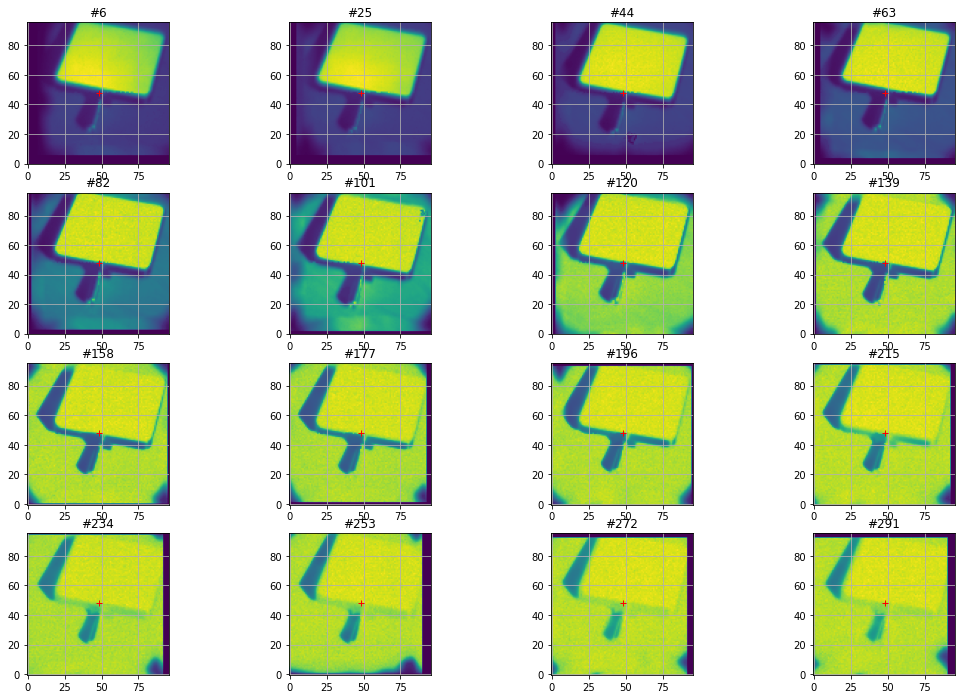

In [14]:
istart=6
step=19#11
nro=4
nco=4
fig,(ax) = matplot.pyplot.subplots(nrows=nro, ncols=nco,figsize=(18, 12))#
i=0
for a in range(0,nro):
    for b in range(0,nco):
        ax[a,b].imshow(ImSPOCinst.data_3D[:,:,istart+i*step],origin='lower'),ax[a,b].plot(48,48,'r+')
        ax[a,b].set_title('#'+str(istart+i*step))#,fontsize=20
        ax[a,b].grid(visible=1)
        i+=1

(Text(0.5, 0, 'Thumbnail#'), Text(0, 0.5, 'Normalized lvl'))

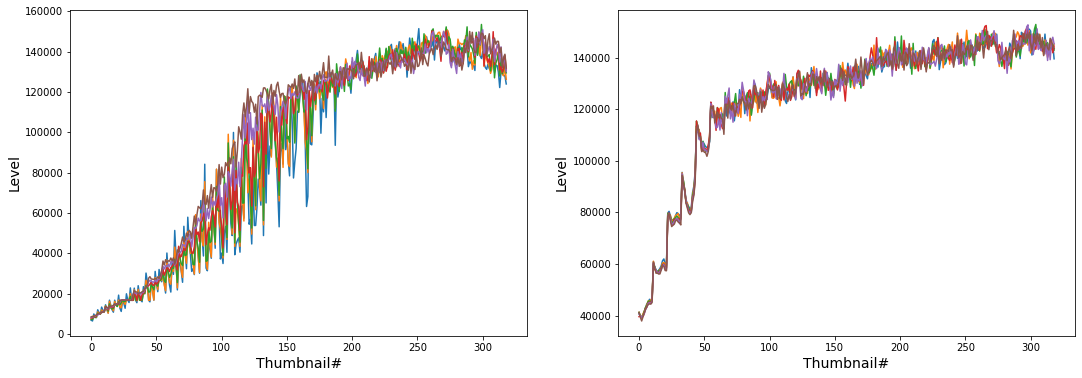

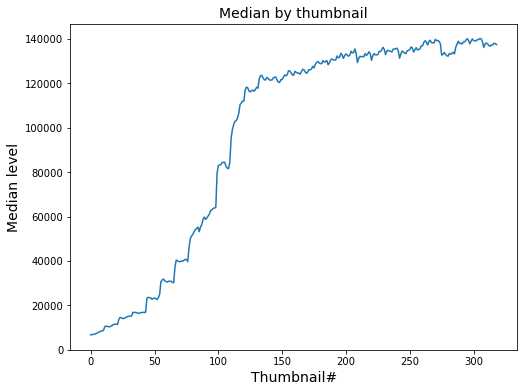

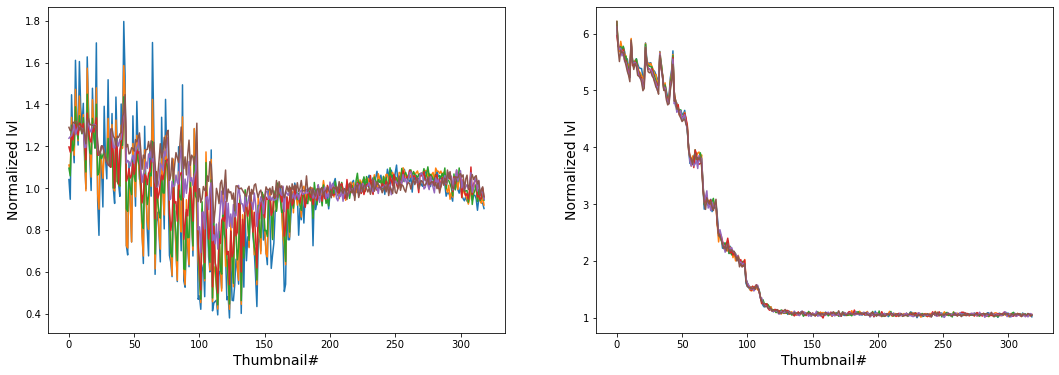

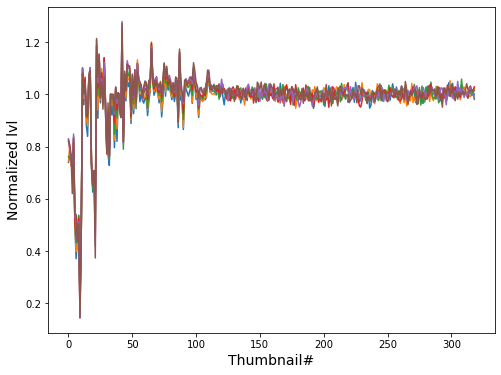

In [15]:
##test de crop pour repérage coordonnée /!\ DEJA COORDONNEES Y (axe verticale) PUIS X (axe horizontal)
#imcrop=ImSPOCinst.data_3D[20:40,50:70,272]
#fig,(ax) = matplot.pyplot.subplots(nrows=1, ncols=1,figsize=(12, 8))#
#ax.imshow(imcrop,origin='lower')

medthumb=np.median(ImSPOCinst.data_3D,axis=(0,1))

fig,(ax) = matplot.pyplot.subplots(nrows=1, ncols=2,figsize=(18, 6))#
xaxis=np.arange(0,ImSPOCinst.nthumbt)
ax[0].plot(xaxis,ImSPOCinst.data_3D[40,50,:],xaxis,ImSPOCinst.data_3D[39,50,:],xaxis,ImSPOCinst.data_3D[38,50,:],xaxis,ImSPOCinst.data_3D[37,50,:],xaxis,ImSPOCinst.data_3D[36,50,:],xaxis,ImSPOCinst.data_3D[35,50,:])
ax[0].set_xlabel('Thumbnail#',fontsize=14),ax[0].set_ylabel('Level',fontsize=14)
ax[1].plot(xaxis,ImSPOCinst.data_3D[60,50,:],xaxis,ImSPOCinst.data_3D[61,50,:],xaxis,ImSPOCinst.data_3D[62,50,:],xaxis,ImSPOCinst.data_3D[63,50,:],xaxis,ImSPOCinst.data_3D[64,50,:],xaxis,ImSPOCinst.data_3D[65,50,:])
ax[1].set_xlabel('Thumbnail#',fontsize=14),ax[1].set_ylabel('Level',fontsize=14)

fig,(ax) = matplot.pyplot.subplots(nrows=1, ncols=1,figsize=(8, 6))#
xaxis=np.arange(0,ImSPOCinst.nthumbt)
ax.plot(xaxis,medthumb)
ax.set_xlabel('Thumbnail#',fontsize=14),ax.set_ylabel('Median level',fontsize=14)
ax.set_title('Median by thumbnail',fontsize=14)

fig,(ax) = matplot.pyplot.subplots(nrows=1, ncols=2,figsize=(18, 6))#
xaxis=np.arange(0,ImSPOCinst.nthumbt)
ax[0].plot(xaxis,ImSPOCinst.data_3D[40,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[39,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[38,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[37,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[36,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[35,50,:]/medthumb)
ax[0].set_xlabel('Thumbnail#',fontsize=14),ax[0].set_ylabel('Normalized lvl',fontsize=14)
ax[1].plot(xaxis,ImSPOCinst.data_3D[60,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[61,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[62,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[63,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[64,50,:]/medthumb,xaxis,ImSPOCinst.data_3D[65,50,:]/medthumb)
ax[1].set_xlabel('Thumbnail#',fontsize=14),ax[1].set_ylabel('Normalized lvl',fontsize=14)

fig,(ax) = matplot.pyplot.subplots(nrows=1, ncols=1,figsize=(8, 6))#
xaxis=np.arange(0,ImSPOCinst.nthumbt)
ax.plot(xaxis,ImSPOCinst.data_3D[40,13,:]/medthumb,xaxis,ImSPOCinst.data_3D[39,13,:]/medthumb,xaxis,ImSPOCinst.data_3D[38,13,:]/medthumb,xaxis,ImSPOCinst.data_3D[37,13,:]/medthumb,xaxis,ImSPOCinst.data_3D[36,13,:]/medthumb,xaxis,ImSPOCinst.data_3D[35,13,:]/medthumb)
ax.set_xlabel('Thumbnail#',fontsize=14),ax.set_ylabel('Normalized lvl',fontsize=14)


### 6 - Extraction de spectre
#### 6.A - Chargement des données de calibration traitées, instanciation et recalage sub-pixel

In [16]:
map_coef=np.load(r'C:\Users\goussets\DATA_ACQ\LVF_GEN0\CALIBRATION\20221212_scanZolix_hdr\zolix\mapcoef_fit.npy')
map_norm=np.load(r'C:\Users\goussets\DATA_ACQ\LVF_GEN0\CALIBRATION\20221212_scanZolix_hdr\zolix\map_norm.npy')

In [17]:
thumbsize=[96,96]
thumbpitch=[96,96]
winsize=[80,80]
_startpix=[1403,537]
ImSPOC_lmbd0=ImSPOCDataClass(map_coef[:,:,2],' ',thumbsize=thumbsize,thumbpitch=thumbpitch,winsize=winsize,_startpix=_startpix)
ImSPOC_norm=ImSPOCDataClass(map_norm,' ',thumbsize=thumbsize,thumbpitch=thumbpitch,winsize=winsize,_startpix=_startpix)

In [18]:
ImSPOC_lmbd0.set_subpixtranslation(pix_displ_all.reshape(np.shape(ImSPOCinst.centre)))
ImSPOC_norm.set_subpixtranslation(pix_displ_all.reshape(np.shape(ImSPOCinst.centre)))

DEV set_subpixtranslation not tested
DEV make_thumb_registration not tested
DEV set_subpixtranslation not tested
DEV make_thumb_registration not tested


#### 6.B - Image pseudo-panchromatique

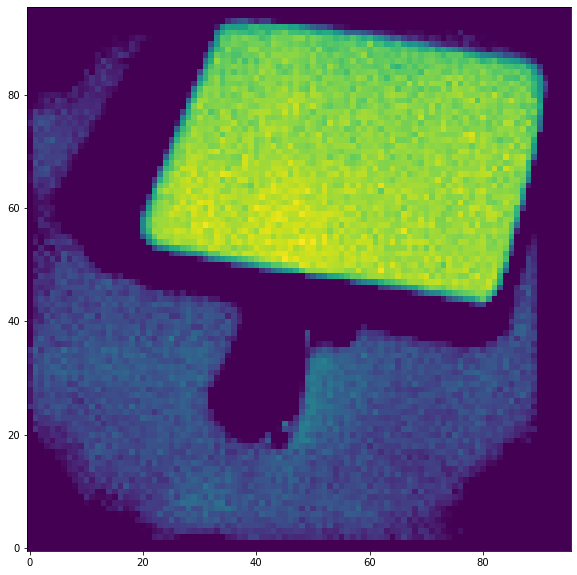

In [19]:
impanchr=np.median(ImSPOCinst.data_3D,axis=2)

fig, (ax) = matplot.pyplot.subplots(1,1,figsize=(10, 10))#,figsize=(8, 6)
ax.imshow(impanchr,origin='lower',vmin=0.9*np.max(impanchr),vmax=1*np.max(impanchr))#,vmin=0,vmax=1000

#### 6.C - Normalisation par valeur médiane d'imagette spectrale ?

In [20]:
ImSPOC_mxgauss=ImSPOCDataClass(map_coef[:,:,0],' ',thumbsize=thumbsize,thumbpitch=thumbpitch,winsize=winsize,_startpix=_startpix)

med_spectThumb=extract_3dmed(ImSPOC_mxgauss.data_3D,[48,48],70)

#### 6.D - Pixel selection et traitement
> Pas de normalisation spectrale effectuée à ce niveau

([<matplotlib.lines.Line2D at 0x22047d1b040>],
 Text(0.5, 1.0, 'Normalized by "Spectral median by thumbnails"'),
 [(430.0, 810.0), Text(0.5, 0, '$\\lambda$ [nm]')])

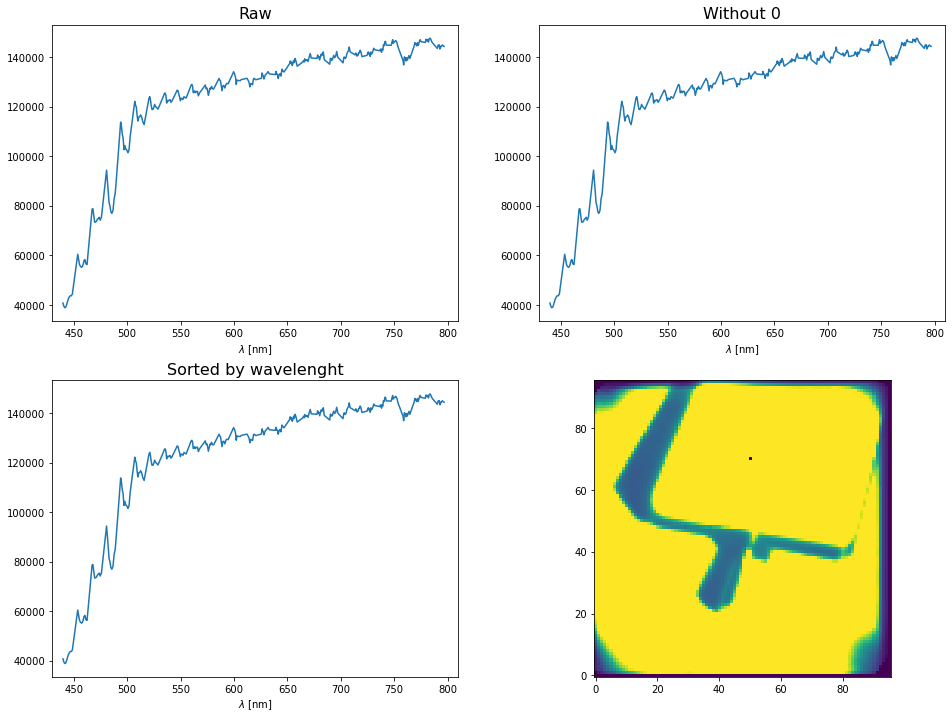

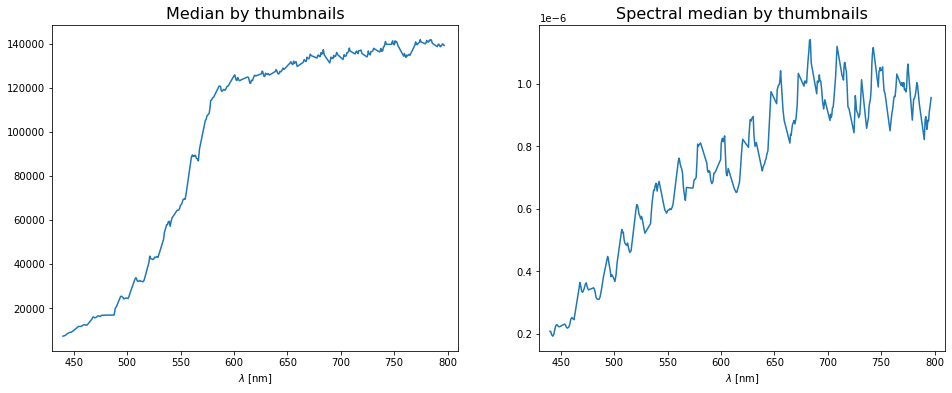

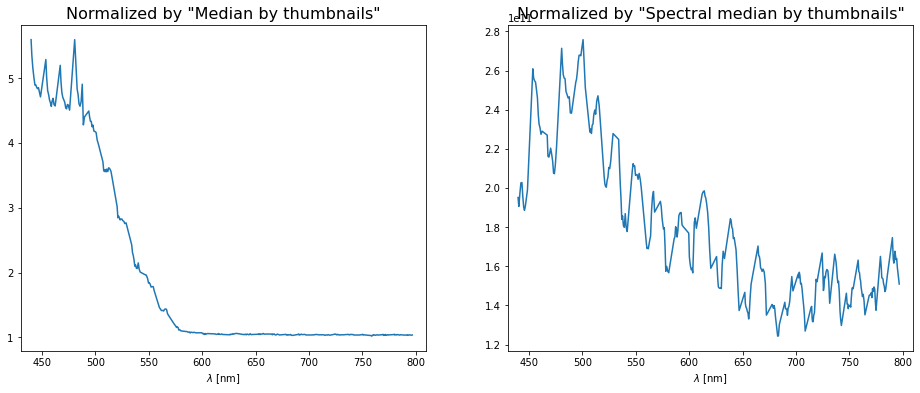

In [21]:
coord_fov=[50,70]#[40,20] #[45,60]# X puis Y
win_med=10

lmbd=extract_3dmed(ImSPOC_lmbd0.data_3D,coord_fov,win_med)
norm=extract_3dmed(ImSPOC_norm.data_3D,coord_fov,win_med)
courant=extract_3dmed(ImSPOCinst.data_3D,coord_fov,win_med)

medtot=extract_3dmed(ImSPOCinst.data_3D,[48,48],70)

#lmbd=ImSPOC_lmbd0.data_3D[coord_fov[1],coord_fov[0],:] # . Lambda scale
#norm=ImSPOC_norm.data_3D[coord_fov[1],coord_fov[0],:]  # . Normalization coefficient
#norm=ImSPOC_gaussmax.data_3D[coord_fov[1],coord_fov[0],:]  # . Normalization coefficient
#courant=ImSPOCinst.data_3D[coord_fov[1],coord_fov[0],:] # . Raw signal

# . Filtering of 0-points
ind0=np.where(lmbd != 0.) 
lmbd_0=lmbd[ind0]
norm_0=norm[ind0]
courant_0=courant[ind0]
medtot_0=medtot[ind0]
med_spectThumb_0=med_spectThumb[ind0]


# . Sorting
isort=np.argsort(lmbd_0)
lmbd_s=lmbd_0[isort]
norm_s=norm_0[isort]
courant_s=courant[isort]
medtot_s=medtot_0[isort]
med_spectThumb_s=med_spectThumb_0[isort]

courant_norm=courant_s/norm_s

imaff=(np.zeros(np.shape(impanchr))+1.)*impanchr
imaff[coord_fov[1],coord_fov[0]]=0
fig,(ax) = matplot.pyplot.subplots(nrows=2, ncols=2,figsize=(16, 12))#
ax[0,0].plot(lmbd,courant),ax[0,0].set_title('Raw',fontsize=16),ax[0,0].set(xlim=(430,810),xlabel='$\lambda$ [nm]')
ax[0,1].plot(lmbd_0,courant_0),ax[0,1].set_title('Without 0',fontsize=16),ax[0,1].set(xlim=(430,810),xlabel='$\lambda$ [nm]')
#ax[1,0].plot(lmbd_s,courant_norm),ax[1,0].set_title('',fontsize=16),ax[1,0].set(xlim=(430,810))
ax[1,0].plot(lmbd_s,courant_s),ax[1,0].set_title('Sorted by wavelenght',fontsize=16),ax[1,0].set(xlim=(430,810),xlabel='$\lambda$ [nm]')
ax[1,1].imshow(imaff,origin='lower',vmin=0,vmax=0.75*np.max(imaff))#,vmin=0,vmax=1000

imaff[coord_fov[1],coord_fov[0]]=0
fig,(ax) = matplot.pyplot.subplots(nrows=1, ncols=2,figsize=(16, 6))#
ax[0].plot(lmbd_s,medtot_s),ax[0].set_title('Median by thumbnails',fontsize=16),ax[0].set(xlim=(430,810),xlabel='$\lambda$ [nm]')
ax[1].plot(lmbd_s,med_spectThumb_s),ax[1].set_title('Spectral median by thumbnails',fontsize=16),ax[1].set(xlim=(430,810),xlabel='$\lambda$ [nm]')
#ax[1].plot(lmbd_s,courant_s/medtot_s),ax[1].set_title('Normalized by "Median by thumbnails"',fontsize=16),ax[1].set(xlim=(430,810),xlabel='$\lambda$ [nm]')

imaff[coord_fov[1],coord_fov[0]]=0
fig,(ax) = matplot.pyplot.subplots(nrows=1, ncols=2,figsize=(16, 6))#
ax[0].plot(lmbd_s,courant_s/medtot_s),ax[0].set_title('Normalized by "Median by thumbnails"',fontsize=16),ax[0].set(xlim=(430,810),xlabel='$\lambda$ [nm]')
ax[1].plot(lmbd_s,courant_s/med_spectThumb_s),ax[1].set_title('Normalized by "Spectral median by thumbnails"',fontsize=16),ax[1].set(xlim=(430,810),xlabel='$\lambda$ [nm]')